# Adaptive RAG

Adaptive RAG is a strategy for RAG that unites (1) [query analysis](https://blog.langchain.dev/query-construction/) with (2) [active / self-corrective RAG](https://blog.langchain.dev/agentic-rag-with-langgraph/).

In the [paper](https://arxiv.org/abs/2403.14403), they report query analysis to route across:

* No Retrieval
* Single-shot RAG
* Iterative RAG

Let's build on this using LangGraph. 

In our implementation, we will route between:

* Web search: for questions related to recent events
* Self-corrective RAG: for questions related to our index

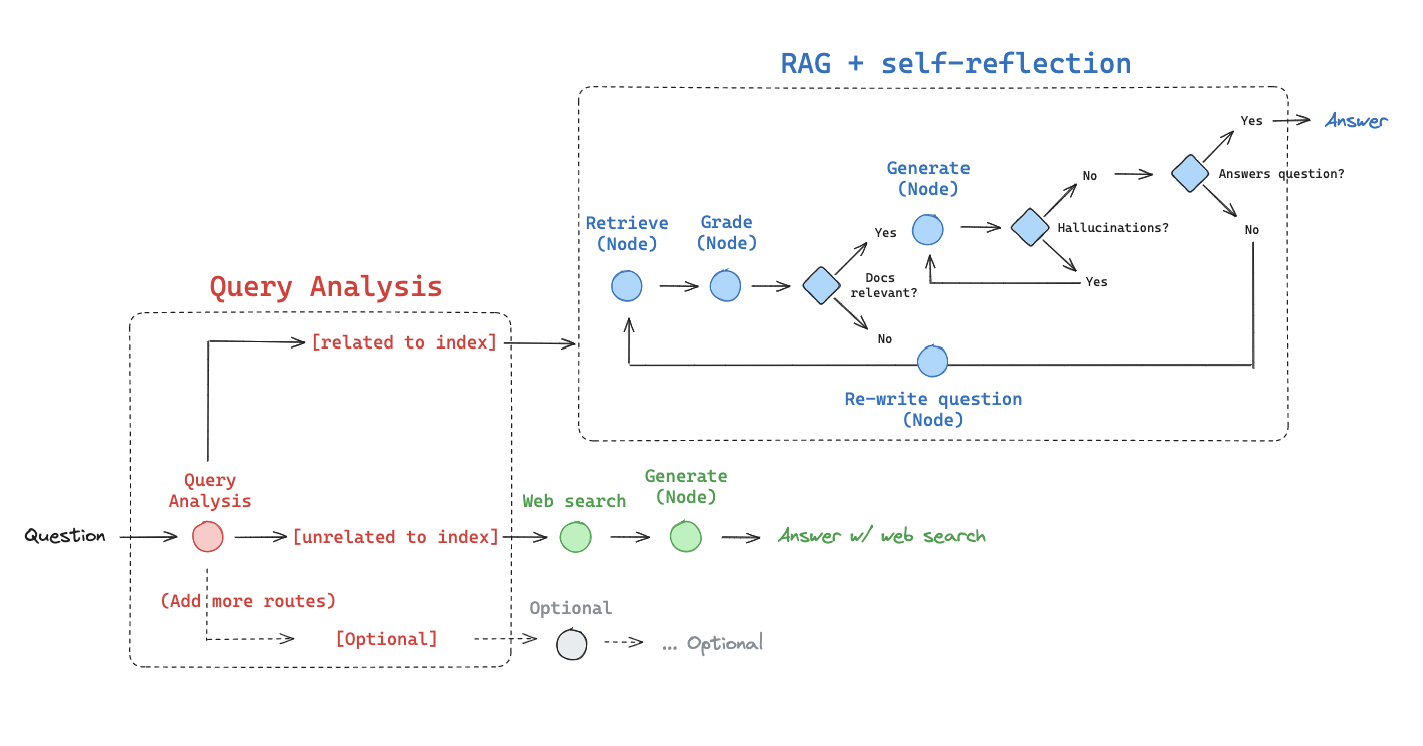

# Environment 

In [ ]:
# %%capture --no-stderr
# ! pip install -U langchain_community tiktoken langchain-openai langchain-cohere langchainhub chromadb langchain langgraph  tavily-python

In [1]:
### LLMs
# import os
# os.environ['OPENAI_API_KEY'] = <your-api-key>
# os.environ['COHERE_API_KEY'] = <your-api-key>
# os.environ['TAVILY_API_KEY'] = <your-api-key>

### Tracing

* Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom) by setting: 

In [2]:
### Tracing (optional)
# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

In [7]:
import os
import logging
from dotenv import load_dotenv

In [8]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

In [9]:
database_uri: str = os.getenv("DATABASE_URL")

## Index

In [11]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
# from langchain_community.vectorstores import Chroma
from langchain.vectorstores.pgvector import DistanceStrategy, PGVector
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
embd = OpenAIEmbeddings(model="text-embedding-3-small")

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
# vectorstore = Chroma.from_documents(
#     documents=doc_splits,
#     collection_name="rag-chroma",
#     embedding=embd,
# )


INFO:langchain_community.document_loaders.web_base:fake_useragent not found, using default user agent.To get a realistic header for requests, `pip install fake_useragent`.
INFO:langchain_community.document_loaders.web_base:fake_useragent not found, using default user agent.To get a realistic header for requests, `pip install fake_useragent`.
INFO:langchain_community.document_loaders.web_base:fake_useragent not found, using default user agent.To get a realistic header for requests, `pip install fake_useragent`.


In [15]:
len(doc_splits)

88

In [25]:
for doc_split in doc_splits:
    print(doc_split.metadata["title"], "-"*10, doc_split.page_content[:30])

LLM Powered Autonomous Agents | Lil'Log ---------- LLM Powered Autonomous Agents 
LLM Powered Autonomous Agents | Lil'Log ---------- The agent learns to call exter
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 1. Overview of a LLM-powe
LLM Powered Autonomous Agents | Lil'Log ---------- Self-reflection is a vital asp
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 2.  Examples of reasoning
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 4. Experiments on AlfWorl
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 5. After fine-tuning with
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 7. Comparison of AD, ED, 
LLM Powered Autonomous Agents | Lil'Log ---------- Sensory memory as learning emb
LLM Powered Autonomous Agents | Lil'Log ---------- LSH (Locality-Sensitive Hashin
LLM Powered Autonomous Agents | Lil'Log ---------- ScaNN (Scalable Nearest Neighb
LLM Powered Autonomous Agents | Lil'Log ---------- Fig. 9. Comparison of MIPS alg
LLM Powered Auto

In [39]:
vectorstore = PGVector(
    connection_string=database_uri,
    embedding_function=embd,
    collection_name="langgraph_adaptive_rag",
    distance_strategy=DistanceStrategy.COSINE,
)
search_kwargs = {
    "k": 5,
    "score_threshold": 0.2,
}

retriever = vectorstore.as_retriever(
    search_type="similarity_score_threshold", search_kwargs=search_kwargs
)

/Users/may/.virtualenvs/generative_ai/lib/python3.11/site-packages/langchain_community/vectorstores/pgvector.py:322: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata.Please note that filtering operators have been changed when using JSOB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create adb migration for your metadata column to be JSONB and update your queries to use the new operators. 
  warn_deprecated(


In [12]:
# retriever.add_documents(doc_splits)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['1017420d-449e-4c91-b142-7942cd654b8f',
 '197e7054-b94c-41fc-88ed-e357bca7aea9',
 'fa683270-ae9f-4011-8754-371f410498fc',
 'a5c2c627-dbe4-4725-b776-4f7db7d5fc71',
 '6cd7e922-5bba-48ab-b8c8-d29c5995c000',
 '9f22b674-db31-43ca-b477-6c00cc11efb8',
 'dd5d6f66-b496-4328-b99b-d234fed29e2a',
 'ed018029-1fa8-4f96-a22b-ba13c160e6e5',
 '270d5322-6a42-47d9-8f77-536f15400f99',
 '4567588e-a0f4-47f2-85e5-9e9633b66e74',
 'f993d142-a1a7-4843-bc2b-3d522c19df5f',
 'f52c6b06-77e4-4b6e-bf28-69a49a9c6a93',
 'e34d0163-936c-4f31-89f1-c5d4c753b4cc',
 'c2487931-813c-4b4a-ba9c-292bca037629',
 '20c6006a-fcae-45a0-b33d-0913d3c38528',
 '4eef46fe-91ea-42bb-8fbc-1e54de1cf0de',
 '2cf871d0-e95e-4e9b-9c2b-b4375e6beebe',
 '14673e8e-305d-47bb-9a95-113f9570967e',
 '5de640b0-b8c4-43d3-b04d-3ec2dcd6ba14',
 '30e7b960-6698-4b07-8404-a51c2fa53039',
 '3e46b123-d250-4403-b5d6-8510e991b04c',
 '7e3b3ce9-2087-41c1-829a-1d58313ac4e7',
 '449fde3e-d2fa-413a-b352-a23c6507be68',
 '1b9f84bf-db3f-4b2e-90e6-c7a32a8eb814',
 '7001ab54-2bee-

In [40]:
relevant_docs = retriever.invoke("Planning is essential")
print(len(relevant_docs))
print(relevant_docs)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


5
[Document(page_content='Planning is essentially in order to optimize believability at the moment vs in time.\nPrompt template: {Intro of an agent X}. Here is X\'s plan today in broad strokes: 1)\nRelationships between agents and observations of one agent by another are all taken into consideration for planning and reacting.\nEnvironment information is present in a tree structure.\n\n\n\n\nFig. 13. The generative agent architecture. (Image source: Park et al. 2023)\nThis fun simulation results in emergent social behavior, such as information diffusion, relationship memory (e.g. two agents continuing the conversation topic) and coordination of social events (e.g. host a party and invite many others).\nProof-of-Concept Examples#\nAutoGPT has drawn a lot of attention into the possibility of setting up autonomous agents with LLM as the main controller. It has quite a lot of reliability issues given the natural language interface, but nevertheless a cool proof-of-concept demo. A lot of cod

## LLMs

In [41]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [42]:
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


datasource='web_search'


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


datasource='vectorstore'


In [44]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [46]:
question = "agent memory"
docs = retriever.get_relevant_documents(question)
print(len(docs))
print(docs)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


5
[Document(page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, s

In [47]:
doc_txt = docs[0].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


binary_score='yes'


In [48]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

input_variables=['context', 'question'] metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]


In [49]:
# LLM
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Agent memory in LLM-powered autonomous agents consists of short-term and long-term memory. Short-term memory involves in-context learning within the finite context window of the model. Long-term memory leverages an external vector store for retaining and recalling information over extended periods, accessible via fast retrieval methods like Maximum Inner Product Search (MIPS).


In [50]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


GradeHallucinations(binary_score='yes')

In [51]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


GradeAnswer(binary_score='no')

In [52]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'What is the role and function of agent memory in artificial intelligence systems?'

## Web Search Tool

In [53]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Graph 

Capture the flow in as a graph.

## Graph state

In [54]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Graph Flow 

In [55]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

In [56]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

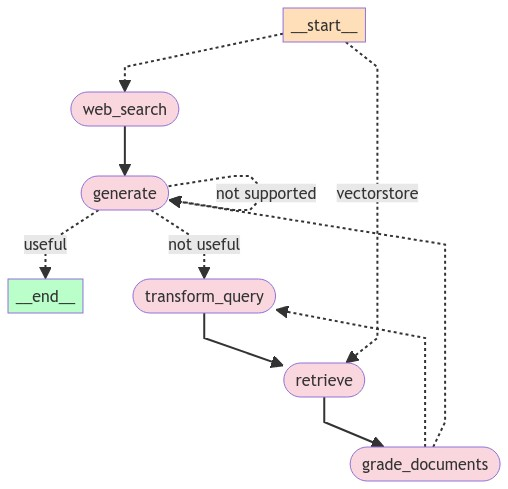

In [57]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [58]:
from pprint import pprint

# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---CHECK HALLUCINATIONS---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The Bears expected to draft USC quarterback Caleb Williams first in the 2024 '
 'NFL Draft.')


Trace: 

https://smith.langchain.com/public/7e3aa7e5-c51f-45c2-bc66-b34f17ff2263/r

In [59]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---ROUTE QUESTION TO RAG---
---RETRIEVE---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---GRADE: DOCUMENT NOT RELEVANT---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---GRADE: DOCUMENT RELEVANT---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---GRADE: DOCUMENT RELEVANT---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---GRADE: DOCUMENT NOT RELEVANT---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---CHECK HALLUCINATIONS---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The types of agent memory are sensory memory, short-term memory, and '
 'long-term memory. Sensory memory involves learning embedding representations '
 'for raw inputs. Short-term memory is used for in-context learning and is '
 'limited by the context window length of the Transformer. Long-term memory is '
 'an external vector store accessible via fast retrieval.')


Trace: 

https://smith.langchain.com/public/fdf0a180-6d15-4d09-bb92-f84f2105ca51/r